# Memory layout and Numpy arrays

## Memory layouts

We can imagine memory as a linear collection of consecutive memory addresses (each one representing one byte).


![Byte array in memory](./img/byte_array.png)

The key to efficient data representations is to order data spatially local in memory. This means that the data we want to work on next should be as close to our current data as possible. The reason is that memory accesses in modern computers are extremely expensive compared to actual computations. In order to alleviate this problem all modern CPUs rely on sophisticated caches that try to read data ahead of time from the memory. This works only if the next pieces of data are close to the data that we are currently working on.

Standard Python list types do not guarantee this locality. List elements can be at very different memory addresses, making standard lists are other base Python types unsuitable for numerical operations. What we require is a buffer type that guarantees us a chunk of consecutive addresses in the system memory.

What happens if we have a matrix? Consider a 2 x 2 matrix

$$
A = \begin{bmatrix} 1 & 2\\ 3 & 4\end{bmatrix}
$$

We have two ways of ordering this matrix across the memory band

* **C-Style ordering:** This aligns the matrix row by row in memory. Hence, our memory buffer will have four elements that read

$$
1, 2, 3, 4
$$

* **Fortran Style ordering:** This aligns the matrix column by column in memory. Our memory buffer will now have four elements that read

$$
1, 3, 2, 4
$$

Both memory layout styles are used across scientific computing, and it is important to know what the assumed layout in a given numerical library is. Ignoring data layouts leads to inefficiency if code has to translate on the fly between the layouts, or even bugs if the layout differences are ignored by a library.

## Numpy to the rescue

[Numpy](https://numpy.org/) solves all these problems by providing an array type that reserves consecutive chunks of memory and allows the user to transparently map data onto this chunk of memory, either using C-style ordering (default), or Fortran-style ordering (optional). Numpy also guarantees that operations between arrays of different orderings are executed correctly (although we should avoid this). Numpy has long established as the de facto standard for array types in Python. Indeed, many other libraries have taken over the Numpy syntax and conventions to make their data types interoperate nicely with Numpy.

**Numpy is a major reason for the large success of Python.**

Very recently an associated [Numpy paper](https://www.nature.com/articles/s41586-020-2649-2) was published in Nature, something very rare for a software library and demonstrating how fundamental Numpy has become to any kind of science that relies on data processing. Most of these operations are implemented by calling natively into accelerated BLAS/Lapack functions.

## BLAS and Lapack

[BLAS (Basic Linear Algebra Subroutines)](http://www.netlib.org/blas/) defines a set of interfaces to standard linear algebra functions. There are three BLAS Variantes, Level 1, 2, and 3.

* BLAS Level 1 defines functions that require $O(n)$ computational complexity ($n$ is the number of element), such as vector addition, multiplication with scalars or dot products.
* BLAS Level 2 defines functions that require $O(n^2)$ computational complexity, such as matrix-vector products, or triangular solves.
* BLAS Level 3 defines functions that require $O(n^3)$ computational complexity, of which the most important one is the matrix-matrix product.

There exists a reference BLAS implementation from http://www.netlib.org. However, this should never be used in practice. The key to fast BLAS operations are implementations that optimally use the CPU Cache architecture to minimize data transfer delays. There exist a number of BLAS libraries that are optimised for modern CPUs, and do not only exploit caching but also SIMD acceleration and multi-core processing (we will discuss these topics later). Examples of such libraries are [Intel MKL](https://software.intel.com/content/www/us/en/develop/tools/math-kernel-library.html), [Openblas](https://www.openblas.net/) or [BLIS](https://github.com/flame/blis).

[Lapack](http://netlib.org/lapack) is a library of advanced linear algebra functions such as linear system solves, eigenvalue problems, singular values, least-squares problems, etc., that make use of BLAS. Lapack routines are highly optimised to use matrix-matrix Level-3 BLAS operations whenever possible. The reason is memory efficiency. The ratio of computational complexity to memory complexity for matrix-matrix products is $O(n^3)$ to $O(n^2)$. Hence, for larger problems we have far more operations than memory accesses, which is what we want as memory accesses are slow.

Numpy links against available BLAS and Lapack libraries to make sure to have the most efficient implementations of linear algebra operations available. If Numpy is installed from conda-forge, then by default the Openblas library is used. Alternatively, one can also use Intel MKL.




## Getting started in Numpy

To get started we import Numpy.

In [16]:
import numpy as np

The basic data type in Numpy is the array. The following creates a double precision array with three entries.

In [19]:
a = np.array([3.5, 4, 18.1], dtype='float64')

The parameter `dtype="float64"` is not necessary here as Numpy automatically recognizes that the list contains two floating point numbers and therefore uses a 64 bit floating point number (double precision) as default type. To use single precision use ``dtype=float32``. A list of available types can be found [here](https://numpy.org/devdocs/user/basics.types.html).

Below are some ways to create an array with Numpy.

In [20]:
a_random = np.random.rand(10) # A random array with 10 components
a_ones = np.ones((10, 10), dtype='float64') # A 10x10 matrix of ones, stored as double precision (float64) type
a_zeros = np.zeros(((10, 10, 10)), dtype='complex128') # A complex three dim. Tensor with all entries set to zero.
a_empty = np.empty(50, dtype='byte') # An unitialized byte array that can store 50 bytes.
a_range = np.arange(50) # The first 50 integers, starting at 0.

We can easily access the shape of an array

In [21]:
print(a_range.shape)
print(a_zeros.shape)

(50,)
(10, 10, 10)


Accessing elements is easy.

In [22]:
a_random[0] # Element 0

0.968195988006513

In [4]:
a_random[:2] # The first two elements 

array([0.40009539, 0.71934764])

In [5]:
a_random[-2:] # The last two elements

array([0.5445252, 0.4253604])

In [6]:
a_ones[:3, 2:5] # The third to fifth column in the first three rows

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [7]:
a_zeros[3, 2, 1] # The element with indices (3, 2, 1)

0j

Assigning elements works similarly.

In [23]:
a_ones[3, 3] = 10
a_ones[:, 4] = np.arange(10)
a_ones[8] = 10 # This sets the whole of row 8 to the entry 10
print(a_ones)

[[ 1.  1.  1.  1.  0.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  2.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. 10.  3.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  4.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  5.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  6.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  7.  1.  1.  1.  1.  1.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [ 1.  1.  1.  1.  9.  1.  1.  1.  1.  1.]]


Together with Matplotlib we can easily plot data.

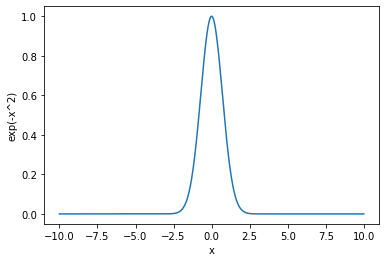

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

x = np.linspace(-10, 10, 10000)
y = np.exp(-x**2)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('exp(-x^2)')
plt.show()

Matrix/Matrix and Matrix/vector products in Numpy are executed as follows:

In [26]:
A = np.random.randn(100, 100)
B = np.random.randn(100, 100)

C = A @ B # Product of the matrices A and B

Note that the componentwise product of two matrices is written as `C = A * B` and has nothing to do with the matrix/matrix product.

Numpy can also solve Linear systems of equations and perform other higher order matrix operations.
To solve a linear system of equations, the following can be used.

In [28]:
A = np.random.rand(1000, 1000)
b = np.random.rand(1000)
x = np.linalg.solve(A, b)

We can easily compute the relative residual of this solve as

In [33]:
residual = np.linalg.norm(b - A @ x) / (np.linalg.norm(A) * np.linalg.norm(x))
print(residual)

1.9058815227064712e-16


The system was solved with an accuracy close to machine precision.

This was just a small sample of Numpy functions. For a more comprehensive introduction check out the [Numpy user guide](https://numpy.org/devdocs/user/index.html)